<h3>File written by David Benisty and Denitsa Staicova</h3> If you use it or parts of it, please cite <a href="https://arxiv.org/abs/2009.10701"> arXiv:2009.10701 [astro-ph.CO]</a><br>
Title: Covariance test Lambda-CDM v.1 <br>
Last update: 15.12.2020

In [37]:
#import matplotlib.pyplot as plt
import numpy as np
from numpy import pi, log, sqrt, power
import time

import random

import scipy.special
from scipy.integrate import odeint
import getdist
from getdist import plots, MCSamples
from scipy.optimize import minimize

%matplotlib inline
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D # <--- This is important for 3d plotting 

import pypolychord
from pypolychord.settings import PolyChordSettings
from pypolychord.priors import UniformPrior, GaussianPrior

import scipy.optimize as op
from numpy.linalg import inv

In [3]:
# load Cosmic Chronometers dataset
ccData = np.genfromtxt("./BAO/CC.txt")
# load Pantheon dataset
panthData = np.genfromtxt("./BAO/binned_data.txt")
panthData = panthData[np.argsort(panthData[:,1])]
# load GRB dataset
GRBData = np.genfromtxt("./BAO/GRB.txt")
# load Quzars
QuData = np.genfromtxt("./BAO/Quasars.txt")


#loading BAO data
dirBD= "./BAO/uncorBAO.txt"
#dirDJ= "./BAO/data.txt"
BaoData = np.genfromtxt(dirBD)
xarr = np.array(BaoData[:,0])    
yarr = np.array(BaoData[:,1])
dyarr = np.array(BaoData[:,2])

funarr = np.genfromtxt(dirBD,dtype='str')[:,3]
print(funarr)

def modelArr(name):
    mod = []

    for j in range(len(funarr)):
        if (funarr[j] == name):
             mod.append([xarr[j],yarr[j],dyarr[j]])
    mod = np.array(mod)
    mod = mod[np.argsort(mod[:,0])]
    return mod

['DVratio' 'DVratio' 'DArd' 'rdDV' 'DVratio' 'DArd' 'DVratio' 'Hxrd'
 'DVrd' 'rdDV' 'DHrd' 'rdDV' 'rdDV' 'rdDV' 'DHrd' 'DAratio' 'DAratio']


In [4]:
#H functions
c = 299792.458

def E(theta,z):
    H0, Om, Ol, rd, rat = theta
    return np.sqrt(Om*(1+z)**3 + Ol + (1 - Om - Ol)*(1+z)**4)

def H(theta,z):
    H0, Om, Ol, rd, rat = theta
    arr = []
    
    for j in range(len(z)):
        arr.append(H0*E(theta,z[j]))
    arr = np.array(arr)
    return arr

def Hxrd(theta,z):
    H0, Om, Ol, rd, rat = theta
    arr = []
    
    for j in range(len(z)):
        arr.append(rd*H0*E(theta,z[j]))
    arr = np.array(arr)
    return arr

def Hxratio(theta,z):
    H0, Om, Ol, rd, rat = theta
    arr = []
    
    for j in range(len(z)):
        arr.append(H0*E(theta,z[j])*rat)
    arr = np.array(arr)
    return arr

Hxratio([67,0.31,0.67,150,1],[1,2,3])

array([124.80717127, 218.75269141, 339.19473758])

In [5]:
#DH functions
def DH(theta,z):
    H0, Om, Ol, rd, rat = theta
    arr = []
    
    for j in range(len(z)):
        arr.append(c/(H0*E(theta,z[j])))
    arr = np.array(arr)
    return arr

def DHrd(theta,z):
    H0, Om, Ol, rd, rat = theta
    arr = []
    
    for j in range(len(z)):
        arr.append(c/(H0*E(theta,z[j])*rd))
    arr = np.array(arr)
    return arr

DHrd([67,0.31,0.67,150,1],[1,2,3])

array([16.0136342 ,  9.13641964,  5.89223878])

In [6]:
def Sk(theta,x):
    H0, Om, Ol, rd, rat = theta 
    Ok = 0
    if Ok < 0:
        return np.sin(np.sqrt(-Ok)*x)/np.sqrt(-Ok)
    if Ok == 0:
        return x
    if Ok > 0:
        return np.sinh(np.sqrt(Ok)*x)/np.sqrt(Ok)

In [7]:
# function that returns dDC/dz,df/dz
def dchidz(x,z, H0, Om, Ol, rd, rat):
    return 1/E([H0, Om, Ol, rd, rat],z)

def chiInt(theta,z):
    H0, Om, Ol, rd, rat = theta 
    z = np.hstack((np.array((0)), z))
    arr = odeint(dchidz,0,z,args=(H0, Om, Ol, rd, rat,))
    return np.delete(arr ,0)

chiInt([67,0.31,0.67,150,1],[1,2,3])

array([0.7514202 , 1.15761318, 1.40342713])

In [8]:
#DM 

def DM(theta,z):
    H0, Om, Ol, rd, rat = theta 
    chi = chiInt(theta,z)
    
    arr = []
    
    for i in range(len(z)):
        arr.append(c*Sk(theta,chi[i])/H0)
    arr = np.array(arr)
    arr.shape
    return arr

def DMrd(theta,z):
    H0, Om, Ol, rd, rat = theta 
    chi = chiInt(theta,z)
    
    arr = []
    
    for i in range(len(z)):
        arr.append(c*Sk(theta,chi[i])/(H0*rd))
    arr = np.array(arr)
    arr.shape
    return arr

def DMratio(theta,z):
    H0, Om, Ol, rd, rat = theta 
    chi = chiInt(theta,z)
    
    arr = []
    
    for i in range(len(z)):
        arr.append(c*Sk(theta,chi[i])/(H0*rat))
    arr = np.array(arr)
    arr.shape
    return arr

DMratio([67,0.31,0.67,150,1],[1,2,3])

array([3362.24043022, 5179.75672582, 6279.6547533 ])

In [9]:
#DA 

def DA(theta,z):
    H0, Om, Ol, rd, rat = theta 
    chi = chiInt(theta,z)
    
    arr = []
    
    for i in range(len(z)):
        arr.append(c*Sk(theta,chi[i])/(H0*(z[i]+1)))
    arr = np.array(arr)
    arr.shape
    return arr

def DArd(theta,z):
    H0, Om, Ol, rd, rat = theta 
    chi = chiInt(theta,z)
    
    arr = []
    
    for i in range(len(z)):
        arr.append(c*Sk(theta,chi[i])/(H0*rd*(z[i]+1)))
    arr = np.array(arr)
    arr.shape
    return arr

def DAratio(theta,z):
    H0, Om, Ol, rd, rat = theta 
    chi = chiInt(theta,z)
    
    arr = []
    
    for i in range(len(z)):
        arr.append(c*Sk(theta,chi[i])/(H0*rat*(z[i]+1)))
    arr = np.array(arr)
    arr.shape
    return arr

DAratio([67,0.31,0.67,150,1],[1,2,3])

array([1681.12021511, 1726.58557527, 1569.91368832])

In [10]:
#DV 

def DV(theta,z):
    H0, Om, Ol, rd, rat = theta 
    dh = DH(theta,z)  
    dm = DM(theta,z)
    arr = []
    
    for i in range(len(z)):
        arr.append(np.cbrt(z[i]*dh[i]*dm[i]**2))
    arr = np.array(arr)
    arr.shape
    return arr

def DVrd(theta,z):
    H0, Om, Ol, rd, rat = theta 
    dh = DH(theta,z)  
    dm = DM(theta,z)
    arr = []
    
    for i in range(len(z)):
        arr.append(np.cbrt(z[i]*dh[i]*dm[i]**2)/rd)
    arr = np.array(arr)
    arr.shape
    return arr

def DVratio(theta,z):
    H0, Om, Ol, rd, rat = theta 
    dh = DH(theta,z)  
    dm = DM(theta,z)
    arr = []
    
    for i in range(len(z)):
        arr.append(np.cbrt(z[i]*dh[i]*dm[i]**2)/rat)
    arr = np.array(arr)
    arr.shape
    return arr

def rdDV(theta,z):
    H0, Om, Ol, rd, rat = theta 
    dh = DH(theta,z)  
    dm = DM(theta,z)
    arr = []
    
    for i in range(len(z)):
        arr.append(rd/(np.cbrt(z[i]*dh[i]*dm[i]**2)))
    arr = np.array(arr)
    arr.shape
    return arr

rdDV([67,0.31,0.67,150,1],[1,2,3])

array([0.04990511, 0.03580299, 0.03183976])

In [11]:
def mu(theta,z):
    DL = DM(theta,z)    
    mu = []
    
    for i in range(len(z)):
        mu.append(5*np.log10(DL[i]*(1+z[i])))
    mu = np.array(mu)
    mu.shape
    return mu

In [12]:
# biuld the covariance matrix
def covFromErr(error):
    num = len(error)
    cov = np.zeros((num,num))
    for j in range(num):
        cov[j,j] = error[j]**2
    return inv(cov)

def randCov(list_length,error):
    num = len(error)
    cov = np.zeros((num,num))
    for j in range(num):
        cov[j,j] = error[j]**2
    # the covariance matrix for the uncorrelated data
    randomList = random.sample(range(len(error)), list_length)
    for i in range(len(randomList)):
        for j in range(len(randomList)):
            if (i!=j):
                cov[i,j] += 0.5*error[i]*error[j]               
    return inv(cov)

In [13]:
# likelihood with covariance matrix
def lnlike(theta,model,x,y,cov):
    chi2 = 0 
    prediction = []
    #x = x*np.ones(len(model))
    for i in range(len(model)):
        fun = model[i]
        prediction.append(eval(fun)(theta,[x[i]]))
    prediction = np.array(prediction)[:,0]
    prediction.shape
    vec = (prediction - y)
    
    result = np.dot(np.dot(vec,cov),vec.T)
    return [result,len(x)-len(theta)]

numUn = 6

print(lnlike([67,0.31,0.67,150,1],funarr,np.array(BaoData[:,0]),np.array(BaoData[:,1]),covFromErr(np.array(BaoData[:,2]))))
print(lnlike([67,0.31,0.67,150,1],funarr,np.array(BaoData[:,0]),np.array(BaoData[:,1]),randCov(numUn,np.array(BaoData[:,2]))))

[37.958897308898, 12]
[40.9350180727839, 12]


In [14]:
def lnlikeBAOun(theta):
    chi, Dof = lnlike(theta,funarr,np.array(BaoData[:,0]),np.array(BaoData[:,1]),covFromErr(np.array(BaoData[:,2])))
    return -chi, [chi, chi/Dof]

def lnlikeBAOunTest(theta):
    chi, Dof = lnlike(theta,funarr,np.array(BaoData[:,0]),np.array(BaoData[:,1]),randCov(numUn,np.array(BaoData[:,2])))
    return -chi, [chi, chi/Dof]

In [15]:
def lnlikeOneMod(theta,model,x,y,cov):
    chi2 = 0 
    prediction = model(theta,x)
    #x = x*np.ones(len(model))
    prediction.shape
    vec = (prediction - y)
    
    result = np.dot(np.dot(vec,cov),vec.T)
    return result


def lnlikeCC(theta):
    chi = lnlikeOneMod(theta,H,ccData[:,0],ccData[:,1],covFromErr(ccData[:,2]))
    return -chi, [chi, chi/(len(ccData[:,0])-len(theta))]

def lnlikeCCun(theta):
    chi = lnlikeOneMod(theta,H,ccData[:,0],ccData[:,1],randCov(numUn,ccData[:,2]))
    return -chi, [chi, chi/(len(ccData[:,0])-len(theta))]

print(lnlikeCC([67,0.31,0.67,150,1]))
print(lnlikeCCun([67,0.31,0.67,150,1]))

(-15.099388356741212, [15.099388356741212, 0.6039755342696485])
(-16.29619719598155, [16.29619719598155, 0.651847887839262])


In [16]:
runs = 50

In [17]:
def dumper(live, dead, logweights, logZ, logZerr):
    print("Last dead point:", dead[-1])

In [18]:
def uniprior(hypercube):
    prior = []
    prior.append(UniformPrior(50.,100.)(hypercube[0]))
    prior.append(UniformPrior(0.,1.)(hypercube[1]))
    prior.append(UniformPrior(0.,1-hypercube[1])(hypercube[2]))
    prior.append(UniformPrior(100,200)(hypercube[3]))
    prior.append(UniformPrior(0.9,1.1)(hypercube[4]))
    return prior

def unipriorRiess(hypercube):
    prior = []
    prior.append(GaussianPrior(74.03,1.42)(hypercube[0]))
    prior.append(UniformPrior(0.,1.)(hypercube[1]))
    prior.append(UniformPrior(0.,1-hypercube[1])(hypercube[2]))
    prior.append(UniformPrior(100,200)(hypercube[3]))
    prior.append(UniformPrior(0.9,1.1)(hypercube[4]))
    return prior

In [19]:
settingsBAOun = PolyChordSettings(5,2)
settingsBAOun.file_root = 'LCDMBAOun50_6'
settingsBAOun.nlive = runs
settingsBAOun.do_clustering = True
settingsBAOun.read_resume = False

settingsBAOunTest = PolyChordSettings(5,2)
settingsBAOunTest.file_root = 'LCDMBAOunCor50_6'
settingsBAOunTest.nlive = runs
settingsBAOunTest.do_clustering = True
settingsBAOunTest.read_resume = False

settingsBAOunR = PolyChordSettings(5,2)
settingsBAOunR.file_root = 'LCDMBAOunR50_6'
settingsBAOunR.nlive = runs
settingsBAOunR.do_clustering = True
settingsBAOunR.read_resume = False

settingsBAOunTestR = PolyChordSettings(5,2)
settingsBAOunTestR.file_root = 'LCDMBAOunCorR50_6'
settingsBAOunTestR.nlive = runs
settingsBAOunTestR.do_clustering = True
settingsBAOunTestR.read_resume = False

In [20]:
outputBAOun = pypolychord.run_polychord(lnlikeBAOun, 5,2, settingsBAOun, uniprior, dumper)
outputBAOunTest = pypolychord.run_polychord(lnlikeBAOunTest, 5,2, settingsBAOunTest, uniprior, dumper)

Last dead point: [ 6.63634350e+01  6.93031537e-01  3.06888376e-01  1.85309273e+02
  1.02307432e+00  1.96801325e+03  1.64001104e+02 -1.00000000e+30
 -1.96801325e+03]
Last dead point: [ 6.08034584e+01  7.80390206e-01  6.68636472e-02  1.02619705e+02
  9.88100605e-01  7.86148216e+02  6.55123513e+01 -1.54680312e+04
 -7.86148216e+02]
Last dead point: [ 6.40603099e+01  9.40318891e-01  2.13528126e-02  1.09748330e+02
  9.87894605e-01  4.73048587e+02  3.94207156e+01 -5.27384317e+02
 -4.73048587e+02]
Last dead point: [ 5.54135572e+01  8.32131819e-01  1.34273065e-01  1.45074628e+02
  1.00668184e+00  3.10733564e+02  2.58944636e+01 -3.86619913e+02
 -3.10733564e+02]
Last dead point: [  66.06352559    0.56349308    0.40541783  123.44460116    0.98592385
  207.76206614   17.31350551 -246.58701165 -207.76206614]
Last dead point: [  65.32969037    0.32848009    0.61867269  150.72106349    1.0085355
  132.49263832   11.04105319 -217.08408734 -132.49263832]
Last dead point: [ 70.1167753    0.17747148   0.7

In [21]:
outputBAOunR = pypolychord.run_polychord(lnlikeBAOun, 5,2, settingsBAOunR, unipriorRiess, dumper)
outputBAOunTestR = pypolychord.run_polychord(lnlikeBAOunTest, 5,2, settingsBAOunTestR, unipriorRiess, dumper)

Last dead point: [ 7.52750853e+01  5.35668968e-01  3.12497670e-01  1.44483122e+02
  9.74824822e-01  1.93638773e+03  1.61365644e+02 -1.00000000e+30
 -1.93638773e+03]
Last dead point: [ 7.20001306e+01  5.91152113e-01  3.26829690e-01  1.17932172e+02
  1.09966196e+00  6.94642437e+02  5.78868698e+01 -9.31781543e+02
 -6.94642437e+02]
Last dead point: [ 7.41817609e+01  5.60044231e-01  4.01653123e-01  1.05874238e+02
  9.72232844e-01  3.86886761e+02  3.22405634e+01 -4.06772021e+02
 -3.86886761e+02]
Last dead point: [ 7.57730149e+01  3.03308307e-01  6.59806967e-01  1.37329409e+02
  9.65101636e-01  1.75599328e+02  1.46332773e+01 -5.75353755e+02
 -1.75599328e+02]
Last dead point: [  74.66478889    0.30507846    0.66005189  131.39063952    0.97150557
   95.47819903    7.95651659 -289.07765806  -95.47819903]
Last dead point: [ 7.58449524e+01  5.46396355e-02  9.02374225e-01  1.51889156e+02
  9.83707259e-01  4.65227049e+01  3.87689208e+00 -5.68411791e+01
 -4.65227049e+01]
Last dead point: [ 72.8846873

In [22]:
paramnames = [('h0','H_0 (km s^{-1} Mpc^{-1})'),('om', '\Omega_m'),('ol', r'\Omega_\Lambda'),('rd','r_d (Mpc)'),('rat','rat'),('L',r'L'),('Ldof',r'L/Dof')]
outputBAOun.make_paramnames_files(paramnames)
outputBAOunTest.make_paramnames_files(paramnames)
outputBAOunR.make_paramnames_files(paramnames)
outputBAOunTestR.make_paramnames_files(paramnames)

posteriorBAOun = outputBAOun.posterior
posteriorBAOunTest = outputBAOunTest.posterior
posteriorBAOunR = outputBAOunR.posterior
posteriorBAOunTestR = outputBAOunTestR.posterior

chains/LCDMBAOun50_6.txt
Removed no burn in
chains/LCDMBAOunCor50_6.txt
Removed no burn in
chains/LCDMBAOunR50_6.txt
Removed no burn in
chains/LCDMBAOunCorR50_6.txt
Removed no burn in


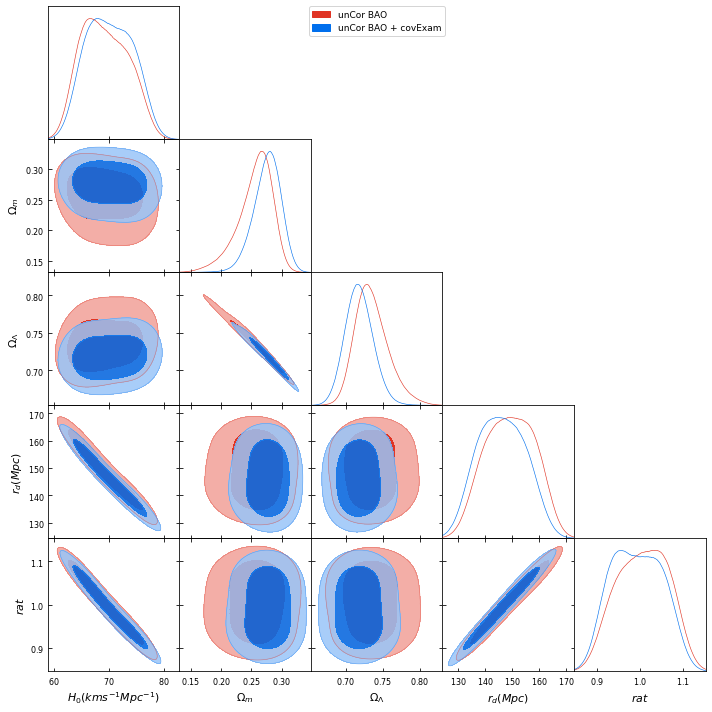

In [23]:
g = getdist.plots.getSubplotPlotter()
g.triangle_plot([posteriorBAOun,posteriorBAOunTest], ('h0','om','ol','rd','rat') ,filled=True, legend_labels=[r'unCor BAO',r'unCor BAO + covExam'])
g.export('crosscheck.pdf')

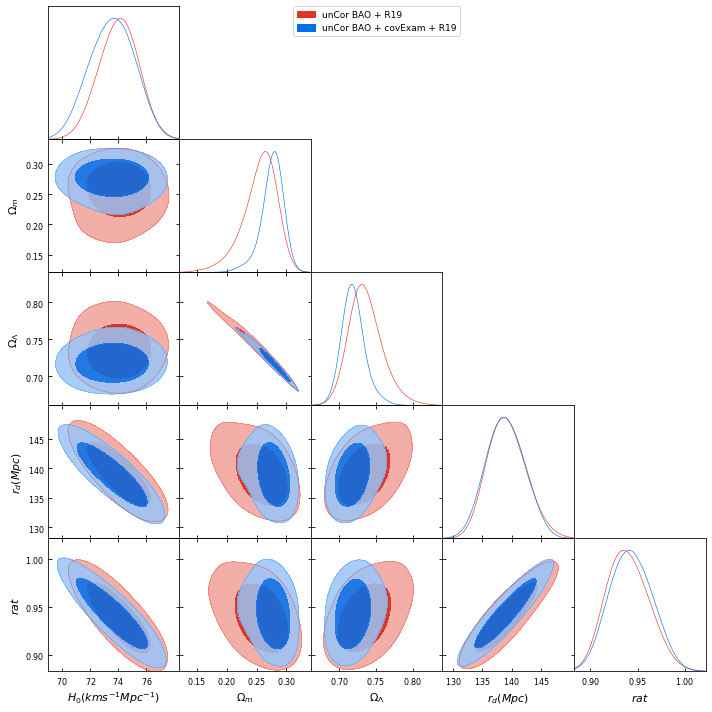

In [24]:
g = getdist.plots.getSubplotPlotter()
g.triangle_plot([posteriorBAOunR,posteriorBAOunTestR], ('h0','om','ol','rd','rat') ,filled=True, legend_labels=[r'unCor BAO + R19',r'unCor BAO + covExam + R19'])
g.export('crosscheckR.pdf')

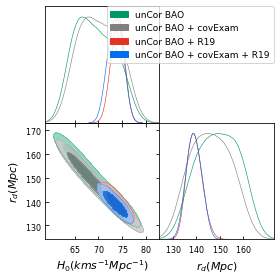

In [33]:
g = getdist.plots.getSubplotPlotter()
g.triangle_plot([posteriorBAOun,posteriorBAOunTest,posteriorBAOunR,posteriorBAOunTestR], ('h0','rd') ,filled=True, legend_labels=[r'unCor BAO',r'unCor BAO + covExam',r'unCor BAO + R19',r'unCor BAO + covExam + R19'])
g.export('crosscheck_50_n6_h0rd.pdf')

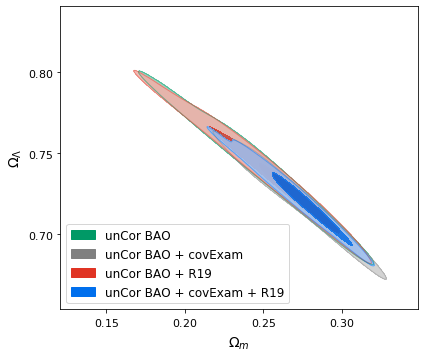

In [34]:
%matplotlib inline
g = plots.get_single_plotter(width_inch=6, ratio=1/1.18)
g.plot_2d([posteriorBAOun,posteriorBAOunTest,posteriorBAOunR,posteriorBAOunTestR], ('om','ol'),filled=True)
g.add_legend([r'unCor BAO',r'unCor BAO + covExam',r'unCor BAO + R19',r'unCor BAO + covExam + R19'], legend_loc='lower left')
g.export('crosscheck_50_n6_omol_s.pdf')

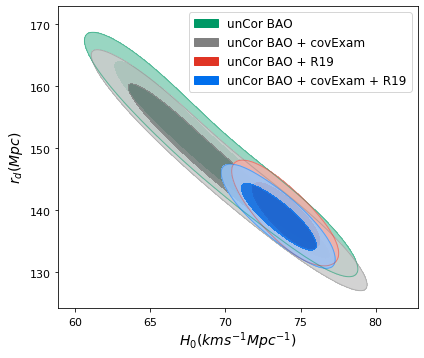

In [35]:
%matplotlib inline
g = plots.get_single_plotter(width_inch=6, ratio=1/1.18)
g.plot_2d([posteriorBAOun,posteriorBAOunTest,posteriorBAOunR,posteriorBAOunTestR], ('h0','rd'),filled=True)
g.add_legend([r'unCor BAO',r'unCor BAO + covExam',r'unCor BAO + R19',r'unCor BAO + covExam + R19'], legend_loc='upper right')
g.export('crosscheck_50_n6_h0rd_s.pdf')

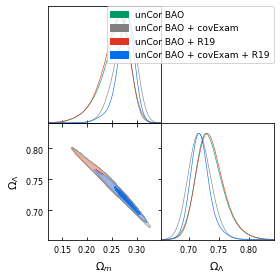

In [36]:
g = getdist.plots.getSubplotPlotter()
g.triangle_plot([posteriorBAOun,posteriorBAOunTest,posteriorBAOunR,posteriorBAOunTestR], ('om','ol') ,filled=True, legend_labels=[r'unCor BAO',r'unCor BAO + covExam',r'unCor BAO + R19',r'unCor BAO + covExam + R19'])
g.export('crosscheck_50_n6_omol.pdf')

In [26]:
def get_constraints(samples):
    for i, mean in enumerate(samples.getMeans()):
        upper = samples.confidence(i, upper=True, limfrac=0.05)
        #print("\nupper limit 95 C.L. = %f" % upper)
        lower = samples.confidence(i, upper=False, limfrac=0.05)
        #print("lower limit 95 C.L. = %f" % lower)
        print("%s = %f +/- %f +/- %f" % (samples.parLabel(i),\

        mean, mean - samples.confidence(i, limfrac=0.16),\
        mean - samples.confidence(i, limfrac=0.025)) )
    return
for i in ["BAOun","BAOunTest", "BAOunR","BAOunTestR"]:
    print(i)
    get_constraints(eval("posterior"+i))

BAOun
H_0 (km s^{-1} Mpc^{-1}) = 69.183415 +/- 4.870284 +/- 6.128958
\Omega_m = 0.256853 +/- 0.027754 +/- 0.073247
\Omega_\Lambda = 0.734912 +/- 0.021891 +/- 0.034723
r_d (Mpc) = 149.339392 +/- 10.830248 +/- 15.021943
rat = 1.007272 +/- 0.073746 +/- 0.098821
L = 10.505111 +/- 1.329565 +/- 1.769686
L/Dof = 0.875426 +/- 0.110797 +/- 0.147474
BAOunTest
H_0 (km s^{-1} Mpc^{-1}) = 70.099158 +/- 4.678650 +/- 6.253865
\Omega_m = 0.276507 +/- 0.021202 +/- 0.044580
\Omega_\Lambda = 0.718029 +/- 0.017744 +/- 0.034876
r_d (Mpc) = 146.132877 +/- 10.027505 +/- 13.929304
rat = 0.992928 +/- 0.067083 +/- 0.089239
L = 15.111639 +/- 1.444992 +/- 2.065121
L/Dof = 1.259303 +/- 0.120416 +/- 0.172093
BAOunR
H_0 (km s^{-1} Mpc^{-1}) = 74.024428 +/- 1.435820 +/- 2.748985
\Omega_m = 0.256051 +/- 0.027256 +/- 0.070318
\Omega_\Lambda = 0.735518 +/- 0.021410 +/- 0.039634
r_d (Mpc) = 139.121557 +/- 3.162082 +/- 5.313771
rat = 0.939530 +/- 0.021946 +/- 0.034064
L = 10.601105 +/- 1.364665 +/- 1.807642
L/Dof = 0.8834

In [30]:
from getdist import loadMCSamples
def get_details(file1, ndims):
    resdict = {}
    # Load from file
    print("Summary")
    samples_polychord = np.loadtxt(file1)
    samples_polychord = samples_polychord[:,-ndims:] # extract the last 'ndims' columns
    # print out the number of posterior samples
    print('Number of posterior samples is {}'.format(np.mean(samples_polychord[:,0])))
    print('Number of posterior samples is {}'.format(samples_polychord.shape[0]))

    resdict['mpolychord_mu'] = np.mean(samples_polychord[:,0])      # mean of m samples
    resdict['mpolychord_sig'] = np.std(samples_polychord[:,0])      # standard deviation of m samples
    resdict['cpolychord_mu'] = np.mean(samples_polychord[:,1])      # mean of c samples
    resdict['cpolychord_sig'] = np.std(samples_polychord[:,1])      # standard deviation of c samples
    resdict['ccpolychord'] = np.corrcoef(samples_polychord.T)[0,1]  # correlation coefficient between parameters
    resdict['polychord_npos'] = len(samples_polychord)              # number of posterior samples
    #resdict['polychord_time'] = timepolychord                       # run time
    #resdict['polychord_logZ'] = output.logZ                         # log marginalised likelihood
    #resdict['polychord_logZerr'] = output.logZerr 
    print(resdict)
    return 

In [38]:
import getdist.mcsamples
#help(getdist.mcsamples)
for i in NamesP:
    print(eval("posterior"+i).getNumSampleSummaryText())
    print('Marginalised evidence is {} ± {}'.format(eval("output"+i).logZ, eval("output"+i).logZerr))

using 801 rows, 7 parameters; mean weight 0.08782972603476162, tot weight 70.35161055384405
Equiv number of single samples (sum w)/max(w): 70.0
Effective number of weighted samples (sum w)^2/sum(w^2): 267

Marginalised evidence is -23.0327334496606 ± 0.493350255391772
using 860 rows, 7 parameters; mean weight 0.2142268191337656, tot weight 184.2350644550384
Equiv number of single samples (sum w)/max(w): 184.0
Effective number of weighted samples (sum w)^2/sum(w^2): 303

Marginalised evidence is -28.2286654801861 ± 0.505188011063406
using 782 rows, 7 parameters; mean weight 0.18679828029007836, tot weight 146.07625518684128
Equiv number of single samples (sum w)/max(w): 146.0
Effective number of weighted samples (sum w)^2/sum(w^2): 286

Marginalised evidence is -21.2373933585877 ± 0.45471618368511
using 839 rows, 7 parameters; mean weight 0.12447467256887808, tot weight 104.43425028528871
Equiv number of single samples (sum w)/max(w): 104.0
Effective number of weighted samples (sum w)^2